In [20]:
from IPython.core.debugger import set_trace
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import os
import pandas as pd
import pickle
import pyabc

import re
from scipy import stats
import seaborn as sns
import tempfile
import theano.tensor as tt

# local
from lib.prior_generation import min_age_prior

## Data Cleaning

In [21]:
calving_data = pd.read_excel('./data/females_calving_2016 up to date.xlsx')
calving_data

,MICS,HWC numbers,80,81,82,83,84,85,86,87,...,08,09,10,11,12,13,14,15,16,Unnamed: 39
0,H002,3229,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN
1,H004,1422,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H008,1417,NaN,NaN,2.0,1.0,1,2.0,NaN,NaN,...,1.0,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,2.000000,NaN
3,H009,1419,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN
4,H035,2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,H042,1451,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0,...,2.0,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000,NaN
6,H044,1424,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,H065,7002,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,H067,7014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,H102,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,...,1.0,NaN,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,NaN


### Only look at those rows with ids

In [22]:
with_ids = calving_data[calving_data['MICS'].notnull() | calving_data['HWC numbers'].notnull()]
# generate our own id for each whale, which is a composite of MICS and HWC numbers.
with_ids.index = with_ids['MICS'].astype(str) + '-' + with_ids['HWC numbers'].astype(str)
with_ids

,MICS,HWC numbers,80,81,82,83,84,85,86,87,...,08,09,10,11,12,13,14,15,16,Unnamed: 39
H002-3229,H002,3229,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN
H004-1422,H004,1422,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H008-1417,H008,1417,NaN,NaN,2.0,1.0,1,2.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0,NaN
H009-1419,H009,1419,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN
H035-2088,H035,2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H042-1451,H042,1451,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0,...,2.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0,NaN
H044-1424,H044,1424,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H065-7002,H065,7002,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H067-7014,H067,7014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H102-nan,H102,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,...,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN


In [23]:
def yearify(x):
    """
        Convert strings to years.
        
        The data only has years showing last two digits. We want to convert 
        them into a four-digit number.
        
        Parameters:
        
            x: string, two digits
            
        Returns:
        
            integer year with four digits.
    """
    _x = int(x)
    if _x >= 80:
        return 1900 + _x
    else:
        return 2000 + _x

### Make columns four-digit years

This will enable us to add 1 to the year to get the next year. Previously this doesn't necessarily lead to the correct result. For example 1999 was represented as 99. 99 + 1 = 100 instead of 00 (which stood for 2000).

In [24]:
# Remove some columns we don't care about
unsorted_years_xx = list(set(with_ids.columns) - set(['MICS', 'HWC numbers', 'Unnamed: 39']))

# Get the dataframe where columns are of interest
with_ids_unsorted_years_xx = with_ids[unsorted_years_xx]

# Convert each column into a stringified four-digit year
unsorted_years_xxxx = list(
        map(
            lambda x: str(x),
            map(
                yearify,
                with_ids_unsorted_years_xx.columns
            )
        )
    )

with_ids_unsorted_years_xx.columns = unsorted_years_xxxx
with_ids_unsorted_years_xx

,2011,2012,2016,2013,2000,2009,2008,2007,2010,2004,...,1995,1996,1997,1998,1999,2001,2006,2014,2003,2005
H002-3229,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1,1.0,2.0,1.0
H004-1422,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,...,NaN,1.0,2.0,1.0,1.0,2.0,1,NaN,1.0,2.0
H008-1417,1.0,1.0,2.0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,...,NaN,NaN,2.0,NaN,2.0,1.0,2,1.0,1.0,1.0
H009-1419,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,2.0,1,1.0,2.0,2.0
H035-2088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
H042-1451,1.0,NaN,2.0,1.0,1.0,1.0,2.0,1.0,1.0,NaN,...,1.0,2.0,1.0,NaN,1.0,NaN,1,1.0,1.0,2.0
H044-1424,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2.0,2.0,2.0,...,NaN,1.0,1.0,2.0,1.0,2.0,1,NaN,1.0,1.0
H065-7002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H067-7014,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,2.0,1.0,NaN,NaN,1.0,1.0
H102-nan,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0


### Cleaned Matrix

In [25]:
with_ids_sorted_years_xxxx = with_ids_unsorted_years_xx[
    sorted(
        unsorted_years_xxxx
    )
]
with_ids_sorted_years_xxxx

cleaned_matrix = with_ids_sorted_years_xxxx.fillna(value=0).astype(int)
cleaned_matrix


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
H002-3229,1,0,0,1,1,0,0,1,1,2,...,2,1,1,1,1,1,1,1,2,1
H004-1422,0,0,1,2,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
H008-1417,0,0,2,1,1,2,0,0,1,2,...,1,1,1,1,1,1,0,1,1,2
H009-1419,0,0,1,0,0,0,0,1,1,1,...,1,2,1,1,1,1,1,1,2,1
H035-2088,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H042-1451,0,0,0,1,1,0,0,1,2,1,...,1,2,1,1,1,0,1,1,1,2
H044-1424,0,0,1,1,0,1,1,1,1,1,...,2,1,0,2,0,0,0,0,0,0
H065-7002,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
H067-7014,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
H102-nan,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1,1,0,1,1,1


### Heatmap

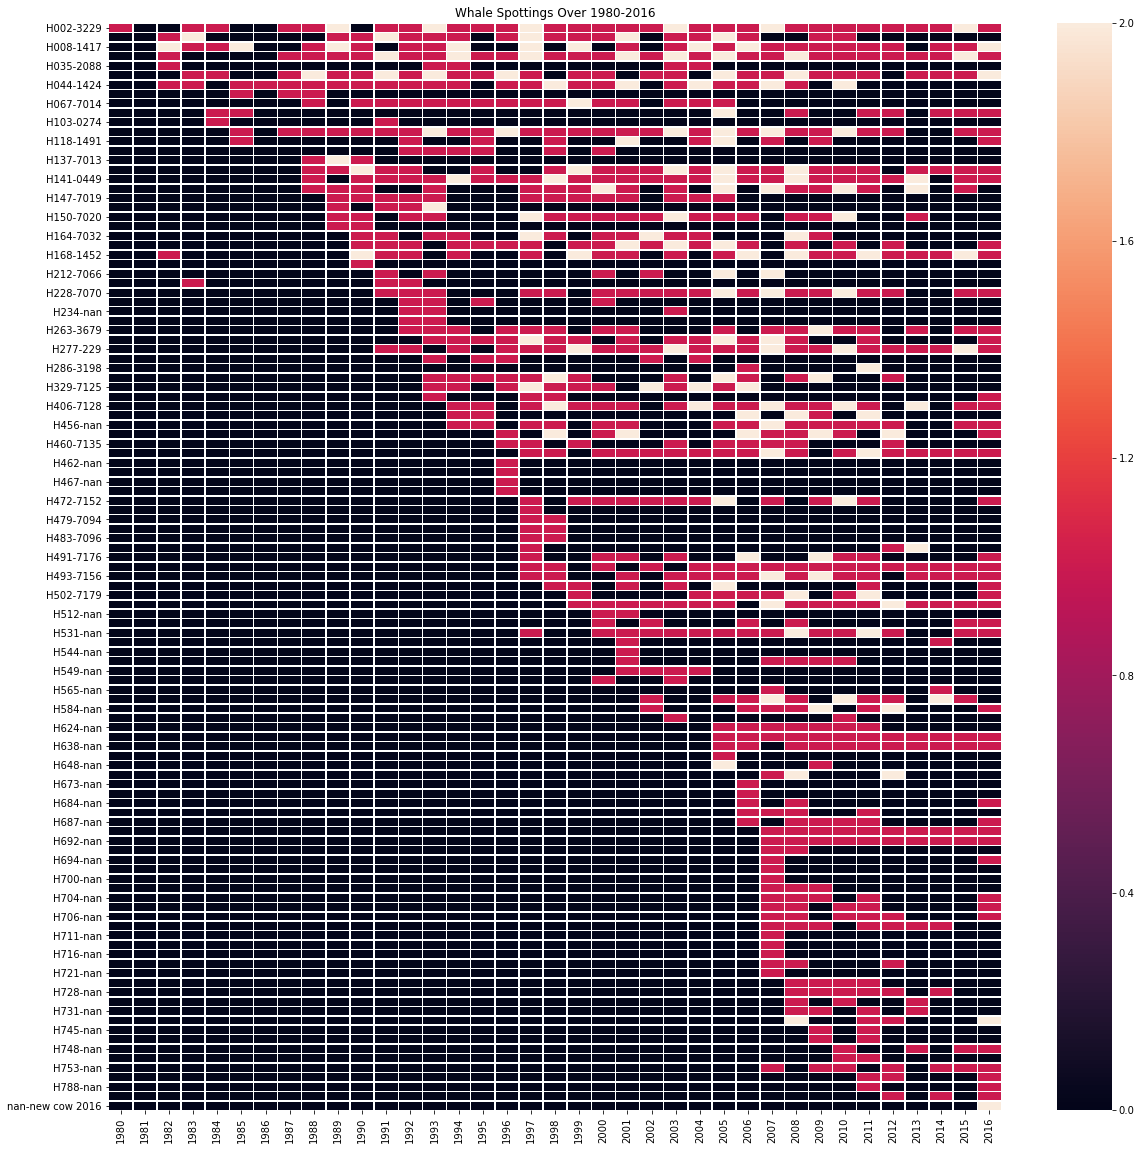

In [26]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.set_title('Whale Spottings Over 1980-2016')
sns.heatmap(cleaned_matrix, ax=ax, linewidths=0.5)

### intro

In [2]:
def intro(age, alive, intro_year_before, proba_intro):
    if age < 0 or (age >= 0 and intro_year_before == 0 and alive == 0):
        return 0
      
    if intro_year_before == 1:
        return 1

    return np.random.binomial(n=1, p=proba_intro)    

### age

In [3]:
def age(age_year_before):
    return age_year_before + 1

### alive

In [4]:
def alive(age, alive_last_year, proba_alive):
    if age < 0:
        return 0
    
    if alive_last_year == 0:
        return 0
    
    return np.random.binomial(n=1, p=proba_alive)

### repro_active

In [5]:
def repro_active(age, alive):
    if alive == 0 or age < 9:
        return 0
    else:
        return 1

### birth

In [6]:
def birth(birth_last_year, repro_active, proba_birth):
    if birth_last_year == 1 or repro_active != 1:
        return 0
    
    return np.random.binomial(n=1, p=proba_birth)

### detect

In [7]:
def detect(intro, alive, proba_detect):
    if intro == 0 or alive == 0:
        return 0
    
    return np.random.binomial(n=1, p=proba_detect)

### count

In [8]:
def count(detect, birth):
    if detect == 1 and birth == 1:
        return 2
    elif detect == 1 and birth == 0:
        return 1
    else:
        return 0

In [9]:

sigma = .5

### model_1

In [ ]:
def model_1(parameters):
    return 

In [10]:
def model(parameters):
    # sample from a gaussian
    y = stats.norm(parameters.x, sigma).rvs()
    # return the sample as dictionary
    return {"y": y}

In [11]:
# We define two models, but they are identical so far
models = [model, model]


# However, our models' priors are not the same.
# Their mean differs.
mu_x_1, mu_x_2 = 0, 1
parameter_priors = [
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_1, sigma)),
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_2, sigma))
]

In [12]:
def distance(x, y):
    return abs(x['y'] - y['y'])

In [13]:
[i for i in reversed(range(11))]

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [14]:

# We plug all the ABC options together
abc = pyabc.ABCSMC(
    models, parameter_priors,
    distance,
    eps=pyabc.ListEpsilon([i for i in reversed(range(11))])
)
    #pyabc.PercentileDistance(measures_to_use=["y"]))



In [15]:
# y_observed is the important piece here: our actual observation.
y_observed = 1
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
abc_id = abc.new(db_path, {"y": y_observed})


INFO:History:Start <ABCSMC(id=6, start_time=2019-08-27 11:13:13.969210, end_time=None)>


In [17]:

# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.5, max_nr_populations=10)



INFO:ABC:t:0 eps:10
INFO:ABC:t:1 eps:9
INFO:ABC:t:2 eps:8
INFO:ABC:t:3 eps:7
INFO:ABC:t:4 eps:6
INFO:ABC:t:5 eps:5
INFO:ABC:t:6 eps:4
INFO:ABC:t:7 eps:3
INFO:ABC:t:8 eps:2
INFO:ABC:t:9 eps:1
INFO:History:Done <ABCSMC(id=6, start_time=2019-08-27 11:13:13.969210, end_time=2019-08-27 11:13:42.503359)>


In [18]:
# Evaluate the model probabililties
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.480000,0.520000
1,0.428382,0.571618
2,0.492288,0.507712
3,0.446792,0.553208
4,0.482455,0.517545
5,0.604750,0.395250
6,0.567104,0.432896
7,0.614419,0.385581
8,0.404452,0.595548


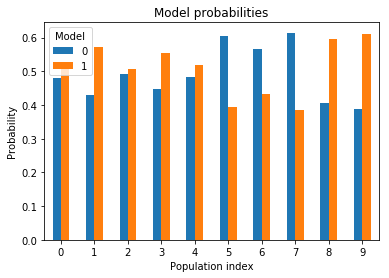

In [19]:
pyabc.visualization.plot_model_probabilities(history)
